<a id='toc'></a>

# Table of contens


[Typing](#typing)

[Helper funcionts](#helperFunctions)

[GA functions](#gaFunctions)

[Optimization](#optimization)

[Evaluation](#evaluation)

[Tests](#tests)

In [1]:
from enum import Enum
import math
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.core.debugger import set_trace
import codecs #used for filereader
import copy
import time
from time import gmtime, strftime
import numpy as np
from multiprocessing.dummy import Pool as ThreadPool 
import os
import gc
from IPython.display import clear_output

%matplotlib inline  


<a id='typing'></a>
# Typing

<a id='handClass'></a>
## Hand class
This class is used to create left and right hand for virtual typing [Go up](#toc)


In [2]:
########## Hand class ######################
class Orientation(Enum):
    LEFT = 0
    RIGHT = 1

class Finger:
    #name = ""
    #currentPosition = (0.0, 0.0)
    #pressCount = 0

    def __init__(self, name, position):
        self.name = name
        self.currentPosition = position
        self.pressCount = 0

class Hand:
    def __init__(self, name, left):
        self.name = name
        self.left = left
        self.index = Finger("index", (0, 0))
        self.middle = Finger("middle", (0, 0))
        self.ring = Finger("ring", (0, 0))
        self.pinky = Finger("pinky", (0, 0))
        self.thumb = Finger("thumb", (0, 0))
        self.goToStartPosition()
        
    
    def goToStartPosition(self):
        #print("Go to start Hand id", id(self))
        yMiddle = 3.8
        xStartMiddle = 4
        yLast = 0
        xSpace = 13.7
        keyDist = 1.8
        
        self.index.pressCount = 0
        self.middle.pressCount = 0
        self.ring.pressCount = 0
        self.pinky.pressCount = 0
        self.thumb.pressCount = 0
        
        self.pressCount = 0
        
        if self.left:
            #Left hand
            self.pinky.currentPosition = (xStartMiddle + 0 * keyDist, yMiddle)
            self.ring.currentPosition= (xStartMiddle + 1 * keyDist, yMiddle)
            self.middle.currentPosition = (xStartMiddle + 2 * keyDist, yMiddle)
            self.index.currentPosition = (xStartMiddle + 3 * keyDist, yMiddle)
            self.thumb.currentPosition = (xSpace, yLast)
            #print("Left Hand Went to start position")
        else:                                                  
            #Right hand                                        
            self.index.currentPosition = (xStartMiddle + 6 * keyDist, yMiddle)
            self.middle.currentPosition = (xStartMiddle + 7 * keyDist, yMiddle)
            self.ring.currentPosition = (xStartMiddle + 8 * keyDist, yMiddle)
            self.pinky.currentPosition = (xStartMiddle + 9 * keyDist, yMiddle)
            self.thumb.currentPosition = (xSpace, yLast)
            #print("Right Hand Went to start position")
            

    def getPressCount(self):
        histList = [self.index.pressCount, self.middle.pressCount, self.ring.pressCount, self.pinky.pressCount] #, self.thumb.pressCount]
        return histList
    
    def getPressCountRel(self):
        totalPressCount = sum(self.getPressCount())
        if totalPressCount == 0:
            histListRel = [0, 0, 0, 0]
        else:
            histListRel = [self.index.pressCount / totalPressCount, 
                           self.middle.pressCount / totalPressCount,
                           self.ring.pressCount / totalPressCount,
                           self.pinky.pressCount / totalPressCount]
                           #self.thumb.pressCount / totalPressCount]
        return histListRel
    
    def copy(self):
        return copy.deepcopy(self)
    

    

        

## KeyboardKey class
This class is used to create the keys of the keyboard [Go up](#toc)

In [3]:
#### KeyboardKey class ############
class KeyboardKey:
    """Class holds information """
    #name = ""
    #position = (0.0, 0.0)
    keyStrokes = 0

    def __init__(self, name : str, position, layer, finger : Finger, hand : Orientation, fixed : int):
        self.name = name 
        self.position = position #Position on keyboard as (x, y) tuple [cm]
        self.layer = layer #Layer of key, base layer = 0, Shift = 1 ...
        self.assignedFinger = finger #Finger assigned to this key
        self.assignedHand = hand #Assigned hand as Orientation Enum: LEFT or RIGHT
        self.keyStrokes = 0 #Number of times this key has been pressed
        self.fixed = fixed #fixed = 0 --> Key can be shifted to another position, fixed = 1 --> Key is fixed


    def pressKey(self):
        self.keyStrokes += 1
        self.assignedFinger.pressCount += 1
        self.assignedFinger.currentPosition = self.position
        # Store typed path
#         keyboard.x.append(self.position[0])
#         keyboard.y.append(self.position[1])

    def calcDistToFinger(self, keyboard):
        p1 = self.assignedFinger.currentPosition
        p2 = self.position
        dist = keyboard.distMap.getDistance(p1, p2)
        return dist
    
    def copy(self):
        return copy.deepcopy(self)
    
    def replaceHand(self, leftHand, rightHand):
        """Function is used to create offsprings which use different hands"""
        if self.assignedHand == Orientation.LEFT:
            if self.assignedFinger.name == "index":
                self.assignedFinger = leftHand.index
            elif self.assignedFinger.name == "middle":
                self.assignedFinger = leftHand.middle
            elif self.assignedFinger.name == "ring":
                self.assignedFinger = leftHand.ring
            elif self.assignedFinger.name == "pinky":
                self.assignedFinger = leftHand.pinky
            elif self.assignedFinger.name == "thumb":
                self.assignedFinger = leftHand.thumb
            else:
                print("Something went wrong 1")
        elif self.assignedHand == Orientation.RIGHT:
            if self.assignedFinger.name == "index":
                self.assignedFinger = rightHand.index
            elif self.assignedFinger.name == "middle":
                self.assignedFinger = rightHand.middle
            elif self.assignedFinger.name == "ring":
                self.assignedFinger = rightHand.ring
            elif self.assignedFinger.name == "pinky":
                self.assignedFinger = rightHand.pinky
            elif self.assignedFinger.name == "thumb":
                self.assignedFinger = rightHand.thumb
            else:
                print("Something went wrong 2")
        else:
            print("Something went wrong 3")
#         print("Hand replaced")




## Keyboard class
This class is used to create the keyboard [Go up](#toc)

In [4]:


class Keyboard:
    """Keyboard class supports typing histogram and distance calculation"""
    createdKeyboards = 0
    deletedKeyboards = 0

    def __init__(self, name, fromFile = True, filePath = "Layouts/Qwertz.csv", keyDict = {}):
        self.name = name
        #Each keyboard has its own pair of hands for typing
        self.leftHand = Hand("leftHand", True)
        self.rightHand = Hand("rightHand", False)
        if fromFile:
            #Load layout from disk
            keyDict = Keyboard.loadKeyLayoutFromDisk(filePath, self.leftHand, self.rightHand)
            self.keyDict = keyDict
        else:
            #Copy layout from existing dict
            newDict = copy.deepcopy(keyDict)
            for key, value in newDict.items():
                value.replaceHand(self.leftHand, self.rightHand)
            self.keyDict = newDict
        self.distMap = DistMap(self) #DistMap contains distances of all keys to all keys
        #Fields for avaluation
        self.fitness = 0 #Overall fitness, field is filled by fitness()
        self.fitnessDist = 0 # Fitness of finger travel, field is filled by fitness()
        self.fitnessHist = 0 # Fitness of finger histogram, field is filled by fitness()
        self.fingerTravel = 0 # Finger travel in cm for a given text, filled by typeText()
        self.errorCount = 0 # Number of chars that could not be typed, filled by typeText()
        self.errorList = [] # List of chars that could not be typed, filled by typeText()
        self.histLeftRel = []
        self.histRightRel = [] 
   
    @staticmethod
    def loadKeyLayoutFromDisk(fileName, leftHand, rightHand):
        """Function returns dictionary with keyboard chars as keys and KeyboardKeys as values
        filName has to point to valid *.csv"""
        
        #Load csv from Layout folder
        #fileStr = "Layouts\\" + name + ".csv"
        df = pd.read_csv(fileName, encoding = "ISO-8859-1", delimiter = ";") ##"Layouts\Qwertz.csv"
        df.head()
        
        char = df["Char"]
        x = df["Xpos"]
        y = df["Ypos"]
        layer = df["Layer"] #layer small chars = 0, capital = 1, AltGr = 2
        hand = df["Hand"] #Left or right
        finger = df["Finger"]
        fixed = df["Fixed"] #Key can not be changed

        keyDict = {}
        for i in range(0, len(x)):
            if hand[i] == "left":
                evalStr = "KeyboardKey(char[i], (x[i], y[i]), layer[i], " + hand[i] + "Hand." + finger[i] + ", Orientation.LEFT, fixed[i])"
                keyboardKey = eval(evalStr)
                #keyboardKey = Key(char[i], (x[i], y[i]), layer[i], leftHand.pinky, Orientation.LEFT)
            if hand[i] == "right":
                evalStr = "KeyboardKey(char[i], (x[i], y[i]), layer[i], " + hand[i] + "Hand." + finger[i] + ", Orientation.RIGHT, fixed[i])"
                #keyboardKey = Key(char[i], (x[i], y[i]), layer[i], rightHand.pinky, Orientation.RIGHT)
                keyboardKey = eval(evalStr)
            #Special handling for enter key (escape char)
            if char[i] == "\\n":
                dictKey = "\n"
            else:
                dictKey = char[i]
                
            keyDict[dictKey] = keyboardKey
        
        return keyDict
    
    def saveKeyboardLayoutToDisk(self, fileName):
        """Function to save Keyboard as *.csv to disk. Omit file ending for file name"""
        
        with  codecs.open(fileName + ".csv", "w", "ISO-8859-1") as f:
            #Write header
            f.write("Char;Xpos;Ypos;Layer;Hand;Finger;Fixed" + "\n")
            for key, value in self.keyDict.items():
                #Special handling for enter key (escape char)
                if key == "\n":
                    chartoWrite = "\\n"
                else:
                    chartoWrite = key
                if value.assignedHand == Orientation.LEFT:
                    handStr = "left"
                else:
                    handStr = "right"
                f.write(chartoWrite + ";" + str(value.position[0]) + ";" + str(value.position[1]) 
                        +";"+ str(value.layer) + ";" + handStr + ";" + str(value.assignedFinger.name)
                        + ";" + str(value.fixed) + "\n")
        fig = plotKeyboard(self)
        fig.savefig(fileName + ".png")
        print(f"Saved layout to: {fileName}")
                
        
    def goToStartPosition(self):
        #print("Keyboard: Going to start position")
        self.leftHand.goToStartPosition()
        self.leftHand.goToStartPosition()
        
    def __del__(self):
        pass
        #print(f"Deleted keyboard {self.name}, {id(self)}")
        
    @staticmethod
    def typeText(wordString, keyboard):
        """Function to calculate finger distance for a given string and Keyboard"""
        #Make sure hands are in starting position
        keyboard.leftHand.goToStartPosition()
        keyboard.rightHand.goToStartPosition()
        wordDist = 0 #Distance the fingers have to travel
        errorCount = 0 #Number of chars that were not found
        errorList = [] # List of all chars that were not found
        for char in wordString:
            try:
                #Check desired layer (Shift, AltGr...)
                if keyboard.keyDict[char].layer == 1:
                    #Press left or right shift based on assigned hand
                    assignedHand = keyboard.keyDict[char].assignedHand
                    if assignedHand == Orientation.LEFT:
                        wordDist += keyboard.keyDict["ShiftRight"].calcDistToFinger(keyboard)
                        keyboard.keyDict["ShiftRight"].pressKey() #Press Shift
                    if assignedHand == Orientation.RIGHT:
                        wordDist += keyboard.keyDict["ShiftLeft"].calcDistToFinger(keyboard)
                        keyboard.keyDict["ShiftLeft"].pressKey() #Press Shift
                if keyboard.name == "QwertzLayout":
                    if keyboard.keyDict[char].layer == 2:
                        wordDist += keyboard.keyDict["AltGr"].calcDistToFinger()
                        keyboard.keyDict["AltGr"].pressKey() #Press Altgr
                if keyboard.name == "Neo2Layout":
                    if keyboard.keyDict[char].layer == 2:
                        assignedHand = keyboard.keyDict[char].assignedHand
                        if assignedHand == Orientation.LEFT:
                            wordDist += keyboard.keyDict["Mod3Right"].calcDistToFinger(keyboard)
                            keyboard.keyDict["Mod3Right"].pressKey() #Press Shift
                        if assignedHand == Orientation.RIGHT:
                            wordDist += keyboard.keyDict["Mod3Left"].calcDistToFinger(keyboard)
                            keyboard.keyDict["Mod3Left"].pressKey() #Press Shift
                    if keyboard.keyDict[char].layer == 3:
                        assignedHand = keyboard.keyDict[char].assignedHand
                        if assignedHand == Orientation.LEFT:
                            wordDist += keyboard.keyDict["Mod4Right"].calcDistToFinger(keyboard)
                            keyboard.keyDict["Mod4Right"].pressKey() #Press Shift
                        if assignedHand == Orientation.RIGHT:
                            wordDist += keyboard.keyDict["Mod4Left"].calcDistToFinger(keyboard)
                            keyboard.keyDict["Mod4Left"].pressKey() #Press Shift

                #Calc distance from current position of assigned finger to next char
                wordDist += keyboard.keyDict[char].calcDistToFinger(keyboard)
                #Press desired key
                keyboard.keyDict[char].pressKey()
            except KeyError:
                #Key not in Dict
                #print("Key: " + char + " not in dictionary")
                if char not in errorList:
                    errorList.append(char)
                errorCount += 1
        #Plot Keyboard
        #plotKeyboard(keyboard)
        keyboard.fingerTravel = wordDist
        keyboard.errorCount = errorCount
        keyboard.errorList = errorList
        
        return wordDist , errorCount, errorList



## Distmap

In [5]:
class DistMap(object):
    """DistMap has distance matrix (as 2 dimensional dictionary) of all keys to all keys that is only calculated once """
    initialized = False
    positionDict = {}
    
    def __init__(self, object):
        if not self.initialized:
            print('Initializing distance map')
          #  print(id(object))
            
            for key1, value1 in object.keyDict.items():
                p1 = value1.position
                posDictRow = {}
                for key2, value2 in object.keyDict.items():
                    p2 = value2.position
                    dist = math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
#                     print(dist)
                    posDictRow[p2] = dist
                    #print(distArr[i,j])
                DistMap.positionDict[p1] = posDictRow
            DistMap.initialized = True
    
    def getDistance(self, p1, p2):
        try:
            dist = DistMap.positionDict[p1][p2]
            return dist
        except:
            raise Exception("Distance between ", p1, " and ", p2, " not available")

<a id='helperFunctions'></a>
# Helper functions

## Filereader

In [6]:

# class FileReader():
#     """description of class"""

#     def __init__(self):
#         pass

def readText(fileName):
    with  codecs.open(fileName, "r", "ISO-8859-1") as f:
        text = f.read()
    return text



## Plot functions
Function to plot keyboard [Go up](#toc)

In [7]:
def plotKeyboard(keyboard, desiredLayer = 0):
    """Plot one layer of keyboard object """
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)

   
    #Plot sourrounding box
    ax.plot([0, 0, 28, 28, 0], [10, -1, -1, 10, 10], color='blue')
    #Plot x-y-Path. Very power intensive for big texts
#     ax.plot(keyboard.x, keyboard.y, color='red')

    for key, value in keyboard.keyDict.items():
        if value.layer == desiredLayer:
            if value.assignedFinger.name == "index" :
                colorStr = "green"
            if value.assignedFinger.name  == "middle" :
                colorStr = "yellow"
            if value.assignedFinger.name == "ring" :
                colorStr = "orange"
            if value.assignedFinger.name  == "pinky" :
                colorStr = "red"
            if value.assignedFinger.name  == "thumb" :
                colorStr = "green"

            ax.text(value.position[0], value.position[1], value.name, bbox={'facecolor': colorStr, 'alpha':0.5, 'pad':5})
   
    return fig

def plotHandHist(axNum, data, nameArr, title):
    """Plot histogram of fingers of left and right hand for up to four keyboards"""
    n_groups = 4 #4Fingers
    index = np.arange(n_groups)
    bar_width = 0.2
    colorArr = ["red", "orange", "gold", "forestgreen"]
    opacity = 1
    
    axNum.grid()
    axNum.set_axisbelow(True)
    
    for i in range(len(data)):
        rects1 = axNum.bar(index + bar_width * i, data[i], bar_width,
                alpha=opacity, color=colorArr[i],
                label=nameArr[i])

    #axNum.set_xlabel('Fingers of left Hand')
    axNum.set_ylabel('Occurance [%]')
    axNum.set_title(title)
    axNum.set_xticks(index + bar_width / 2)
    axNum.set_xticklabels(('Index', 'Middle', 'Ring', 'Pinky'))
    axNum.legend()
    
def plotLeftHandRightHand(axNum, data, nameArr, title):
    """Plot distribution of left and right hand of up to four keyboards"""
    n_groups = 2 #2 Hands
    index = np.arange(n_groups)
    bar_width = 0.2
    colorArr = ["red", "orange", "gold", "forestgreen"]
    opacity = 1
    
    axNum.grid()
    axNum.set_axisbelow(True)
    
    for i in range(len(data)):
        rects1 = axNum.bar(index + bar_width * i, data[i], bar_width,
                alpha=opacity, color=colorArr[i],
                label=nameArr[i])

    #axNum.set_xlabel('Fingers of left Hand')
    axNum.set_ylabel('Occurance [%]')
    axNum.set_title(title)
    axNum.set_xticks(index + bar_width / 2)
    axNum.set_xticklabels(('Left Hand', 'Right Hand'))
    axNum.legend()
    
def plotFingerDistance(ax, data, nameArr, title):
    """Plot finger distance of up to four keyboards"""
    colorArr = ["red", "orange", "gold", "green"]
    bar_width = 0.3

    # Choose the position of each barplots on the x-axis (space=1,4,3,1)
    #x_pos = [0,1,2]
    xPos = np.arange(len(data))

    # Create bars
    ax.bar(xPos, data, bar_width, color = colorArr[0:len(data)])

    # Create names on the x-axis
    #plt.xticks(y_pos, bars)

    ax.set_xticks(xPos)
    # axNum.tick_label(nameArr)
    ax.set_xticklabels(nameArr)
    ax.set_title(title)

    ax.grid()
    ax.set_axisbelow(True)



## Misc Functions

In [8]:
def get_nth_key(dictionary, n=0):
    """Helper function to access dictionary by index"""
    if n < 0:
        n += len(dictionary)
    for i, key in enumerate(dictionary.keys()):
        if i == n:
            return key
    raise IndexError("dictionary index out of range, i = ", i) 

<a id='gaFunctions'></a>
# GA functions
Set of functions for the genetic algorithm [Go up](#toc)

## Create new Members

In [9]:
def create_new_member(name : str, basicKeyboard):
    """Creates a new random keyboard based on the positions from basicKeyboard."""


    #Create a list with all chars that are not fixed
    charList = []
    for key, value in basicKeyboard.keyDict.items():
        if value.layer == 0 and value.fixed == 0:
            charList.append(key)
   
    #Loop through base dictionary and change keys
    #to different positions. The positions itself 
    #remain unchanged
    newDict = {}
    for key, value in basicKeyboard.keyDict.items():
        if value.layer == 0:
            if value.fixed == 0:
                #Pick a random char
#                 rand = int(random.random() * len(charList))
#                 randChar = charList[rand]
                randChar = random.choice(charList)
                charList.remove(randChar)
                #create new key, only change char
                newKey = KeyboardKey(randChar, value.position, value.layer, value.assignedFinger, value.assignedHand, value.fixed)
                #Add new key to new dictionary
                newDict[randChar] = newKey
            if value.fixed == 1:
                #create new key as copy of existing key
                newKey = KeyboardKey(key, value.position, value.layer, value.assignedFinger, value.assignedHand, value.fixed)
                #Add new key to new dictionary
                newDict[key] = newKey

                
    #Create new keyboard
    newKeyboard = Keyboard(name, fromFile=False, keyDict = newDict)
    
    #newKeyboard = Keyboard.fromKeyDict(name, newDict)
    #newKeyboard.keyDict = newDict
        #name, newDict, basicKeyboard.leftHand, basicKeyboard.rightHand)
    #print("Created new member successfully")
    
    return newKeyboard

def create_starting_population(size, basicKeyboard):
    #Create a population of different keyboards
    population = []
    for i in range(0, size):
        name = str(i)
        population.append(create_new_member(name, basicKeyboard))
    return population

## Fitness function

In [10]:
def fitness(wordString, keyboard, wordDistBaseline, histDesired):
    
    wordDist , errorCount, errorList = Keyboard.typeText(wordString, keyboard)

    # Fitness criteria 1: Distance of finger travel
    # Goes from 0 to 1 wheras 0 is the optimum
    fitnessDist = 1 - (wordDistBaseline - wordDist) / wordDistBaseline

    # Fintess criteria 2: Histogram of finger usage
    
    #histDesired = [0.25, 0.25, 0.25, 0.25]
    #Histogram of left and right hand without thumb
#     histLeft = keyboard.leftHand.getPressCountRel()
#     histRight = keyboard.rightHand.getPressCountRel()
    
    histLeft = keyboard.leftHand.getPressCount()
    histRight = keyboard.rightHand.getPressCount()
    
    totalPressCount = sum(histLeft) + sum(histRight)
    
    if totalPressCount != 0:
        histLeftRel = [histVal / totalPressCount for histVal in histLeft]
        histRightRel = [histVal / totalPressCount for histVal in histRight]
    else:
        histLeftRel = 0
        histRightRel = 0
        
#     print(histLeftRel)
#     print(histRightRel)
    
    diffLeft = [abs(x1-x2) for (x1, x2) in zip(histLeftRel, histDesired)]
    diffRight = [abs(x1-x2) for (x1, x2) in zip(histRightRel, histDesired)]

    #Goes from 0 to 1 whereas 0 is the optimum
    fitnessDiff = sum(diffLeft) / 2 + sum(diffRight) / 2
    
    #Combination of both fitness criteria with weights
    fitnessCombined = fitnessDiff * 0.25 + fitnessDist * 0.75
    
    keyboard.fitness = fitnessCombined
    keyboard.fitnessHist = fitnessDiff
    keyboard.fitnessDist = fitnessDist
    keyboard.histLeftRel = histLeftRel
    keyboard.histRightRel = histRightRel
    
    return fitnessCombined


def pick_mate(scores):

    # 29:00 
    # Function to pick mate based on score
    array = np.array(scores)
    temp = array.argsort() #Get indices of sorted array
    ranks = np.empty_like(temp) #Return a new array with the same shape and type as a given array.
    ranks[temp] = np.arange(len(array)) #Return evenly spaced values within a given interval.

    fitness = [len(ranks) - x for x in ranks]
    
    cum_scores = copy.deepcopy(fitness)
    
    for i in range(1,len(cum_scores)):
        cum_scores[i] = fitness[i] + cum_scores[i-1]
        
    probs = [x / cum_scores[-1] for x in cum_scores]
    
    rand = random.random()
    
    for i in range(0, len(probs)):
        if rand < probs[i]:
            return i
        
def score_population(population, wordString, wordDistBaseline, histDesired):
    
    scores = []
    for member in population:
        #wordDist , errorCount, errorList = fitness(wordString, member)
        fitnessCombined = fitness(wordString, member, wordDistBaseline, histDesired)
        scores += [fitnessCombined]
    return scores


# def score_population_parallel(population, wordString, threadPoolCount):

#     scores = []
#     argumentArray = []
#     for member in population:
#         argumentTuple = (wordString, member)
#         argumentArray.append(argumentTuple)
        
# #         wordDist , errorCount, errorList = fitness(wordString, member)
# #         scores += [wordDist]

#     pool = ThreadPool(threadPoolCount) 
#     outputArr = pool.starmap(fitness, argumentArray)
#     scores = [i for i,j,k in outputArr]
    
#     pool.close()
#     pool.join()
    
#     return scores



        


## Repair keyboard

In [11]:
def repairKeyboard(baseKeyboard, keyboardToRepair):
    
    dictBase = baseKeyboard.keyDict
    dictToRepair = keyboardToRepair.keyDict
    # Compare two dictionaries for missing chars and positions
    missingChars = []
    missingPositions = []
    missingKeys = []
    
    existingPositions = []
    
    for key,value in dictToRepair.items():
        existingPositions.append(value.position)

    for key,value in dictBase.items():
      #  flag1 = False
      #  flag2 = False
        if key not in dictToRepair.keys():
            missingChars.append(key)
#             print("missingChar: ", key)
           # flag1 = True
        if value.position not in existingPositions:
            missingPositions.append(value.position)
            missingKeys.append(value)
#             print("missingPosition: ", value.position)
            #flag2 = True
#         if flag1 != flag2:
#             print("Key missing: ", flag1, " Position missing: ", flag2)
#             print("Key = ", key, "Position = ", value.position)
        

    #assert len(missingChars) == len(missingPositions)
    
    if len(missingChars) != len(missingPositions):
        print("unable to repair Layout")
        print("repairLayout: len(missingChars) = ", len(missingChars), "; len(missingPositions) = ", len(missingPositions))
#         print(missingChars)
#         print(missingPositions)
        return dictToRepair
    # Augment dictionary with missing values
        
    for missingKey, missingChar in zip(missingKeys, missingChars):
        newKeyboardKey = copy.deepcopy(missingKey)
        newKeyboardKey.replaceHand(keyboardToRepair.leftHand, keyboardToRepair.rightHand) 
        newKeyboardKey.name = missingChar
        dictToRepair[missingChar] = newKeyboardKey
            
    return keyboardToRepair

def verifyLayout(baseKeyboard, keyboardToVerify):
    
    dictBase = baseKeyboard.keyDict
    dictToVerify = keyboardToVerify.keyDict
    
    if len(dictBase) != len(dictToVerify):
        #print("Length dictBase: ", len(dictBase), "Lenght dictToVerify: ", len(dictToVerify))
        return False
    # Check one dictionary for unique values
    unique = {}
    duplicates= {}
    for key,value in dictToVerify.items():
        if value not in unique.values():
            unique[key] = value
        else:
            duplicates[key] = value
            print("Duplicate value (", value, ") at key: ", key)
    
    if len(unique) != len(dictBase):
        #print("Length dictBase: ", len(dictBase), "Unique values dictToVerify: ", len(unique))
        return False
    return True

def getKeyFromPosition(dict, desiredPosition):
#     print("Dict: ", dict, "Position: ", desiredPosition)
    for key, value in dict.items():
        if (value.position == desiredPosition):
            return key
        
# evalStr = "Key(char[i], (x[i], y[i]), layer[i], " + hand[i] + "Hand." + finger[i] + ", Orientation.LEFT, fixed[i])"
# keyboardKey = eval(evalStr)


## Crossover

In [12]:

def crossover(keyboardA, keyboardB, basicKeyboard):
    """Functio to crossover two keyboards"""
    #Load keyboard from memory for offsprings and change keymapping afterwards
    offspringA = Keyboard("OffspringA", fromFile=False, keyDict= basicKeyboard.keyDict)
    offspringB = Keyboard("OffspringB", fromFile=False, keyDict= basicKeyboard.keyDict)
    
    #Dictionary with chars as Keys and KeyboardKeys as values
    dictA = keyboardA.keyDict
    dictB = keyboardB.keyDict
    #Init new crossed dictionaries
    newDictA = {}
    newDictB = {}
    #blacklist is used to remeber what chars have already been added
    blackListA = []
    blackListB = []
    #Counter to see how many keys from a and b are used
    countA = 0
    countB = 0
    countNewChars = 0
    countFixedChars = 0
    #Loop through dictionary of baseKeyboard and decide randomly for
    #every position if key from keyboardA or KeyboardB is placed for
    #the offspring keyboard 
    for key, value in offspringA.keyDict.items():
        if value.layer == 0:
            if value.fixed == 0:
                countNewChars += 1
                #Take key from A and B at current position from baseKeyboard
                newCharA = getKeyFromPosition(dictA, value.position)
                newCharB = getKeyFromPosition(dictB, value.position)
                #Create new Key for newCharA and newCharB at old position
                #Original hands are replaced with offspring hands
                newKeyboardKeyA = copy.deepcopy(keyboardA.keyDict[newCharA])
                newKeyboardKeyA.position = value.position
                newKeyboardKeyB = copy.deepcopy(keyboardB.keyDict[newCharB])
                newKeyboardKeyB.position = value.position

                rand = round(random.random())
                if rand == 0:
                    #Verify that the key is not already used
                    if newCharA in blackListA:
                        newKeyboardKeyA.replaceHand(offspringB.leftHand, offspringB.rightHand) 
                        newKeyboardKeyB.replaceHand(offspringA.leftHand, offspringA.rightHand) 
                        #Add newCharB to newDictA and vice versa
                        newDictA[newCharB] = newKeyboardKeyB
                        newDictB[newCharA] = newKeyboardKeyA
                        #Place newCharB on blacklist
                        blackListA.append(newCharB)
                        countB += 1
                    else:
                        newKeyboardKeyA.replaceHand(offspringA.leftHand, offspringA.rightHand) 
                        newKeyboardKeyB.replaceHand(offspringB.leftHand, offspringB.rightHand) 
                        #Add newCharA to newDictA and newCharB to newDictB
                        newDictA[newCharA] = newKeyboardKeyA
                        newDictB[newCharB] = newKeyboardKeyB
                        #Place newCharA on blacklist
                        blackListA.append(newCharA)
                        countA += 1
                elif rand == 1:
                    #Verify that the key is not on blacklist. That means the
                    #key is not on a position that is already used
                    if newCharB in blackListA:
                        newKeyboardKeyA.replaceHand(offspringA.leftHand, offspringA.rightHand) 
                        newKeyboardKeyB.replaceHand(offspringB.leftHand, offspringB.rightHand) 
                        #Add newCharA to newDictA and vice versa
                        newDictA[newCharA] = newKeyboardKeyA
                        newDictB[newCharB] = newKeyboardKeyB
                        #Place newCharA on blacklist
                        blackListA.append(newCharA)
                        countA += 1
                    else:
                        newKeyboardKeyA.replaceHand(offspringB.leftHand, offspringB.rightHand) 
                        newKeyboardKeyB.replaceHand(offspringA.leftHand, offspringA.rightHand) 
                        #Add newCharA to newDictB and newCharA to newDictB
                        newDictA[newCharB] = newKeyboardKeyB
                        newDictB[newCharA] = newKeyboardKeyA
                        #Place newCharB on blacklist
                        blackListA.append(newCharB)
                        countB += 1
                else: 
                    print("Crossover error: rand = ", rand)

            elif value.fixed == 1:
                countFixedChars += 1
                #create new key as copy of existing key
                try:
                    newKeyboardKeyA = copy.deepcopy(keyboardA.keyDict[key])
                    newKeyboardKeyA.replaceHand(offspringA.leftHand, offspringA.rightHand) 
                except:
                    print("Key %s not in dictionary of keyboard %s" % (key, keyboardA.name))
                try:
                    newKeyboardKeyB = copy.deepcopy(keyboardB.keyDict[key])
                    newKeyboardKeyB.replaceHand(offspringB.leftHand, offspringB.rightHand) 
                except:
                    print("Key %s not in dictionary of keyboard %s" % (key, keyboardB.name))
                
                #Add new key to new dictionary
                newDictA[key] = newKeyboardKeyA
                newDictB[key] = newKeyboardKeyB
            else:
                print("Crossover: Something went wrong 1")
        else: 
            print("Crossover: Something went wrong layer = ", value.layer)

    
    offspringA.keyDict = newDictA
    offspringB.keyDict = newDictB
    
    resultA = verifyLayout(keyboardA, offspringA)
    if resultA == False:
        #print("Repairing Keyboard A")
        offspringA = repairKeyboard(keyboardA, offspringA)
        resultA = verifyLayout(keyboardA, offspringA)
        #print("Keyboard A repaired: ", resultA)
        
    resultB = verifyLayout(keyboardB, offspringB)
    if resultB == False:
        #print("Repairing Keyboard B")
        offspringB = repairKeyboard(keyboardB, offspringB)
        resultB = verifyLayout(keyboardB, offspringB)
        #print("Keyboard B repaired: ", resultB)

    if resultB == False or resultA == False:
        print("Crossover: Unable to repair new keyboards, returning original")
        return keyboardA, keyboardB
    else:
        return offspringA, offspringB

## Mutate

In [13]:
def mutate(keyboard : Keyboard, probability):
    """Function switches ramdomly 2 keys on a input keyboard and returns a new one"""
    #Change 2 random keys if random number is under threshold  
    if random.random() < probability: 
        #Create copy of key dictionary
        keyDict = keyboard.keyDict #copyKeyDict()
        #Get random char from keydict
        charPos1 = round(random.random() * len(keyDict)) - 1
        char1 = get_nth_key(keyDict, charPos1)
        #Pick new random chars until its not fixed
        while keyDict[char1].fixed != 0:
            charPos1 = round(random.random() * len(keyDict)) - 1
            char1 = get_nth_key(keyDict, charPos1)

        #Get another random char from keydict
        charPos2 = round(random.random() * len(keyDict)) - 1
        char2 = get_nth_key(keyDict, charPos2)
        #Pick new random chars until its not fixed and not the first char
        while keyDict[char2].fixed != 0 or char1 == char2:
            charPos2 = round(random.random() * len(keyDict)) - 1
            char2 = get_nth_key(keyDict, charPos2)

        #Save both keyboard keys
        keyboardKey1 = keyDict[char1]
        keyboardKey2 = keyDict[char2]
        #Delete old key
        del keyDict[char1]
        del keyDict[char2]
        #Switch names
        keyboardKey1.name = char2
        keyboardKey2.name = char1
        #Add updated keyboard keys on different location
        keyDict[char1] = keyboardKey2
        keyDict[char2] = keyboardKey1

<a id='optimization'></a>
# Optimization
Main loop of the genetic Algorithm [Go up](#toc)

## Run Epoch

In [14]:
def runEpoch(population, text, wordDistBaseline, histDesired):
    """population is scored based on text, wordDistBaseline and histDesired
    Return value is a new population based on the results of population"""

    new_population = []

#     if i == 0:
#         #1st run score complete population
#         #scores = score_population_parallel(population, text, number_of_threads)
#         scores = score_population(population, text)
#     else:
#         #Following runs: only score new members of population

#         # Keepers are always at the end of population
#         newInCurrentPopulation = population[0 : len(population) - len(keeperList)] 
#         #Calculate scores of new members
#         #newScores = score_population_parallel(newInCurrentPopulation, text, number_of_threads)
#         newScores = score_population(newInCurrentPopulation, text)
#         #Join list of new and keeper scores
#         scores = newScores
#         scores.extend(keeperScores)

    scores = score_population(population, text, wordDistBaseline, histDesired)
    #scores = score_population_parallel(population, text, number_of_threads)
    # Determine the keyboard with the best result  
    indexWinner = scores.index(min(scores))
    bestKeyboard = population[indexWinner]
    bestKeyboard.name = "Best keyboard"
#     bestKeyboard.fitness = scores[indexWinner]
#     bestKeyboard.fitnessDist = fitnessDistArr[indexWinner]
#     bestKeyboard.fitnessHist = fitnessDiffArr[indexWinner]
    

    #Allow population to breen based on scores
    countOffsprings = 0
    for j in range(0, number_of_couples):  
        partnerA = pick_mate(scores)
        partnerB = pick_mate(scores)
        #print("pick1 = ", partnerA, "pick2 = ", partnerB)
        keyboardA = population[partnerB]
        keyboardB = population[partnerB] 
        new1, new2 = crossover(keyboardA, keyboardB, population[0])
        new_population.append(new1)
        new_population.append(new2)
        countOffsprings += 2

    # Mutate existing members
    countMutated = 0
    for j in range(0, len(new_population)):
        #new_population[j] = np.copy(mutate(new_population[j], 0.05, the_map))
        mutate(new_population[j], mutation_probability)
        countMutated += 1

    # Add best members of previous generation, number can vary because of pick_mate()
    countKeepers = 1
    keeperList = [bestKeyboard]
    keeperScores = [scores[indexWinner]]
    for j in range(1, number_of_winners_to_keep):
        keeper = pick_mate(scores)
        if population[keeper] not in keeperList:
            keeperList.append(population[keeper])
            keeperScores.append(scores[keeper])
            countKeepers += 1

    # Add new random members
    countRandom = 0
    while len(new_population) + len(keeperList) < population_size:
        new_member = create_new_member("new member", population[0])
        new_population.append(new_member)
        countRandom += 1

    #Always add keepers at the end    
    new_population.extend(keeperList)
    
    return new_population, bestKeyboard

    
def printIterationResult(bestKeyboard, timePerLoop, totalTime, remainingTime, i):
    #Format time strings
    timePerLoopStr = "{0:.2f}".format(timePerLoop)
    totalTimeStr = time.strftime("%H:%M:%S", time.gmtime(totalTime))
    remainingTimeStr = time.strftime("%H:%M:%S", time.gmtime(remainingTime))
    curTime = time.strftime("%H:%M:%S", gmtime())
    #Get results 
    wordDist, errorCount , errorList = Keyboard.typeText(text, bestKeyboard)
    leftHandPressCount = bestKeyboard.leftHand.getPressCountRel()
    rightHandPressCount = bestKeyboard.rightHand.getPressCountRel()
    #Format result string
    leftHandPressCountStr = [ "{0:.2f}".format(number) for number in bestKeyboard.histLeftRel]
    rightHandPressCountStr = [ "{0:.2f}".format(number) for number in bestKeyboard.histRightRel]
    wordDistStr = "{0:.2f}".format(wordDist)
    bestFitnessStr = "{0:.3f}".format(bestKeyboard.fitness)
    bestFitnessHistStr = "{0:.3f}".format(bestKeyboard.fitnessHist)
    bestFitnessDistStr = "{0:.3f}".format(bestKeyboard.fitnessDist)
    
    #clear_output()
    
    print(f"-------------------------------{curTime}-------------------------------------")
    print(f"Iteration {i}: Best fitness so far is {bestFitnessStr}, WordDist = {wordDistStr} ")
    print(f"FitnessDist = {bestFitnessDistStr}, FitnessHist = {bestFitnessHistStr}")
    print(f"leftHand: {leftHandPressCountStr}, rightHand: {rightHandPressCountStr}")
    print(f"Ran for {totalTimeStr}, Remaining time {remainingTimeStr}, Time per iteration: {timePerLoopStr}")
    
    


    
    
    

## Main loop

In [15]:
def main(startingPopulation, wordDistBaseline, histDesired):
    lastFitness = 1000000000

    totalTime = 0
    remainingTime = 0
    timePerLoop = 0
    plotFlag = True
    

    fitnessArr = []
    iterationArr = []
    wordDistArr = []
    handDiffArr = []
        
    previousPopulation = startingPopulation
    
    for i in range(0, number_of_iterations):
        
        elapsedTime = 0
        start = time.time()
    
    
        new_population, bestKeyboard = runEpoch(
            previousPopulation, text, wordDistBaseline, histDesired)
        
        end = time.time()
        elapsedTime = end - start
        totalTime += elapsedTime

        timePerLoop = totalTime / (i + 1)

        remainingTime = timePerLoop * (number_of_iterations - i)


        
        #bestKeyboard = new_population[indexWinner]
        
#         print("indexWinner = ", indexWinner)
#         print("bestKeyboard = ", bestKeyboard.name)

        # If its better than the last, give status update
        if bestKeyboard.fitness < lastFitness:
            fitnessArr.append(bestKeyboard.fitness)
            wordDistArr.append(bestKeyboard.fitnessDist)
#             print(i, bestKeyboard.fitness) 
#             print(bestKeyboard.fitnessDist)
#             print(bestKeyboard.fitnessHist)
            handDiffArr.append(bestKeyboard.fitnessHist)
            iterationArr.append(i)
            #print(i, bestFitness, bestDist, bestDiff)
            printIterationResult(bestKeyboard, timePerLoop, totalTime, remainingTime, i)

        if bestKeyboard.fitness == 0:
            break

        
        lastFitness = bestKeyboard.fitness
        previousPopulation = new_population
        
        gc.collect()

    #Score the latest population and print out result       
    scores = score_population(new_population, text, wordDistBaseline, histDesired)
    indexWinner = scores.index(min(scores))
    bestKeyboard = new_population[indexWinner]
    bestKeyboard.name = "Best keyboard"
    
    printIterationResult(bestKeyboard, timePerLoop, totalTime, remainingTime, i)
    
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12, 5))
    # Remove horizontal space between axes
    fig.subplots_adjust(hspace=0.1)

    axs[0].plot(iterationArr, fitnessArr)
    axs[0].set_ylabel('Fitness')
    axs[1].plot(iterationArr, wordDistArr)
    axs[1].set_ylabel("Travel")
    axs[2].plot(iterationArr, handDiffArr)
    axs[2].set_ylabel("Distribution")
    axs[2].set_xlabel('Epoch')
    
    #fig.show()
    
    #figKeyboard = plotKeyboard(bestKeyboard)

    return bestKeyboard, fig

## Run main loop

Initializing distance map
0.49999999999999994
WordDistBaseLine =  390463.6321862551
-------------------------------13:43:31-------------------------------------
Iteration 0: Best fitness so far is 0.698, WordDist = 317457.52 
FitnessDist = 0.813, FitnessHist = 0.353
leftHand: ['0.17', '0.05', '0.22', '0.12'], rightHand: ['0.11', '0.07', '0.05', '0.22']
Ran for 00:00:07, Remaining time 00:00:07, Time per iteration: 7.60
-------------------------------13:43:39-------------------------------------
Iteration 0: Best fitness so far is 0.695, WordDist = 321050.98 
FitnessDist = 0.822, FitnessHist = 0.314
leftHand: ['0.14', '0.28', '0.10', '0.06'], rightHand: ['0.10', '0.05', '0.12', '0.16']
Ran for 00:00:07, Remaining time 00:00:07, Time per iteration: 7.60
Saved layout to: Results\2019.01.18-13-43-bestKeyboard


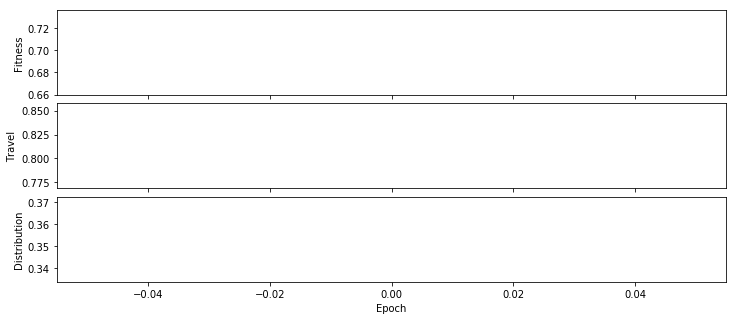

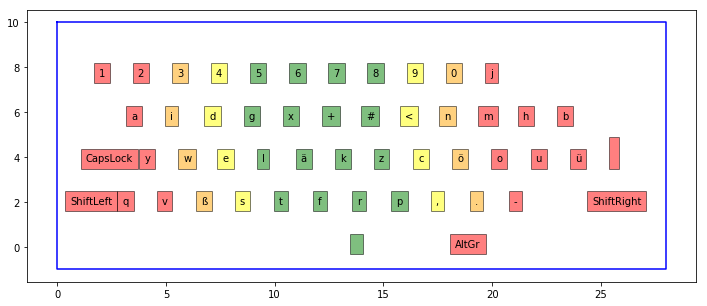

In [16]:
gc.collect()
Keyboard.createdKeyboards = 0

number_of_iterations = 1 #1000
population_size = 15 
number_of_couples = 5
number_of_winners_to_keep = 3
number_of_threads = 10
mutation_probability = 0.5

text = readText("Text/Bogdanow.txt")
text = text.replace("\r", "")
text = text.replace("\t", "")
text = text.lower()
charCount = len(text)

#text = "abcd efgh"


#baseKeyboardPath = "Layouts/Neo2.csv"
baseKeyboard = Keyboard("BaseKeyboard", filePath="Layouts/Qwertz-1Layer.csv")
#baseKeyboard = Keyboard("BaseKeyboard", filePath="Results\\2019.01.16-11-21-bestKeyboard.csv")

# create the starting population
startingPopulation = create_starting_population(population_size - 1, baseKeyboard)
startingPopulation.append(baseKeyboard)

#histDesired = [0.4, 0.3, 0.2, 0.1]
histDesired = [0.25, 0.1, 0.1, 0.05]
print(sum(histDesired))

wordDistBaseline, errorcCount, errorArr = Keyboard.typeText(text, baseKeyboard)
print("WordDistBaseLine = ", wordDistBaseline)


#baseKeyboardPath = "Layouts/Qwertz.csv"

#%prun main(startingPopulation)
best, fig = main(startingPopulation, wordDistBaseline, histDesired)


curDate = time.strftime("%Y.%m.%d-%H-%M", gmtime())

best.saveKeyboardLayoutToDisk("Results\\" + curDate + "-bestKeyboard")
fig.savefig("Results\\" + curDate + "-Epoch.png")




# Evaluation

## Comparison Qwertz - Neo2

Qwertz: dist = 543147.2898394442 cm, errorCount = 9944
['Ã', '¶', '¼', '¤', '\x9f', 'â', '\x94', 'Â', '»', '«', '\x9c', '\x84', '\x96', '\x93']
Neo2: dist = 453655.1873932295 cm, errorCount = 9689
['Ã', '¶', '¼', '¤', '\x9f', 'â', 'Â', '\x9c']


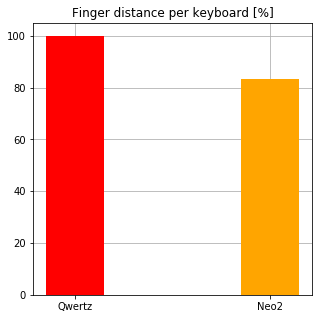

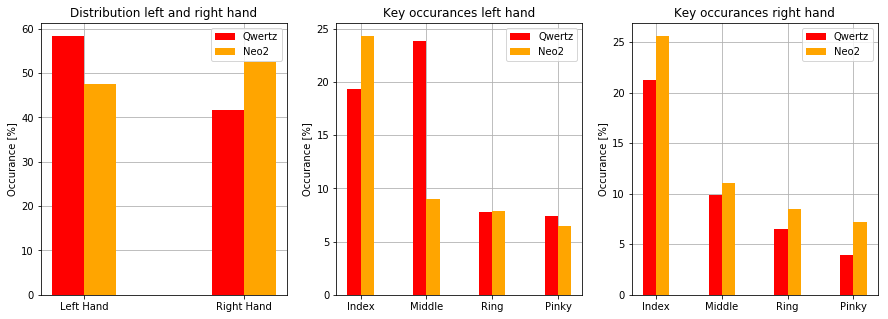

In [17]:
qwertzKeyboard = Keyboard("Qwertz", filePath="Layouts/Qwertz.csv")
neo2Keyboard = Keyboard("Neo2", filePath="Layouts/Neo2.csv")

keyboardList = [qwertzKeyboard, neo2Keyboard]

text = readText("Text/FranzJung.txt")
text = text.replace("\r", "")
text = text.replace("\t", "")
#text = text.lower()

#text = "abcd efgh"

leftHandHistArr = [] # 4 x n array with histogram of four fingers for n keyboards
rightHandHistArr = [] # 4 x n array with histogram of four fingers for n keyboards
keyboardNames = [] # 1 x n array with names of n keyboards
dataLeftRightArr = [] # 2 x n array with distribution of left and right hand 
fingerDistArr = [] # 1 x n array with finger distance of n keyboards



for keyboard in keyboardList:
    #Type text with current keyboard
    Keyboard.typeText(text, keyboard)
    #Get results for fingers of left and right hand
    histLeft = keyboard.leftHand.getPressCount()
    histRight = keyboard.rightHand.getPressCount()
    
    #Calculate distribution over left and right hand
    keyCountTotal = sum(histRight) + sum(histLeft)
    dataLeftRight = [sum(histLeft) / keyCountTotal * 100, sum(histRight) / keyCountTotal * 100]
    dataLeftRightArr.append(dataLeftRight)
                     
    #Calculate relative distribution over fingers of left and right hand
    histLeftRel = [histVal / keyCountTotal * 100 for histVal in histLeft]
    histRightRel = [histVal / keyCountTotal * 100 for histVal in histRight]
    leftHandHistArr.append(histLeftRel)
    rightHandHistArr.append(histRightRel)
    
    #Add finger distance to array
    fingerDistArr.append(keyboard.fingerTravel)
   
    keyboardNames.append(keyboard.name)

# Calculate finger distance in %   
maxFingerDist = max(fingerDistArr)
fingerDistArr = [val / maxFingerDist *100 for val in fingerDistArr]

#Plot results

fig1, ax1 = plt.subplots(figsize=(5, 5))
plotFingerDistance(ax1, data = fingerDistArr, nameArr = keyboardNames, title = 'Finger distance per keyboard [%]')

fig2, ax2 = plt.subplots(1,3, figsize=(15, 5))

plotLeftHandRightHand(ax2[0], data = dataLeftRightArr, nameArr = keyboardNames, title = 'Distribution left and right hand')
plotHandHist(ax2[1], data = leftHandHistArr, nameArr = keyboardNames, title = 'Key occurances left hand')
plotHandHist(ax2[2], data = rightHandHistArr, nameArr = keyboardNames, title = 'Key occurances right hand')


for keyboard in keyboardList:
    print(f"{keyboard.name}: dist = {keyboard.fingerTravel} cm, errorCount = {keyboard.errorCount}")
    print(keyboard.errorList)




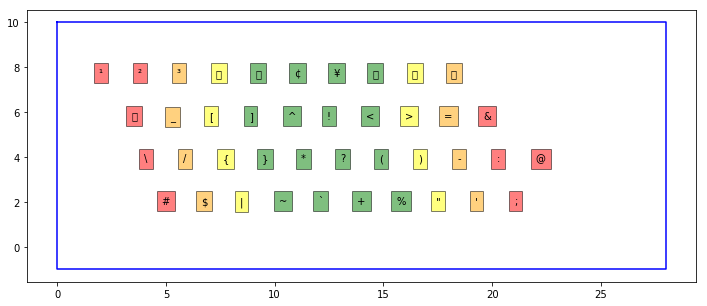

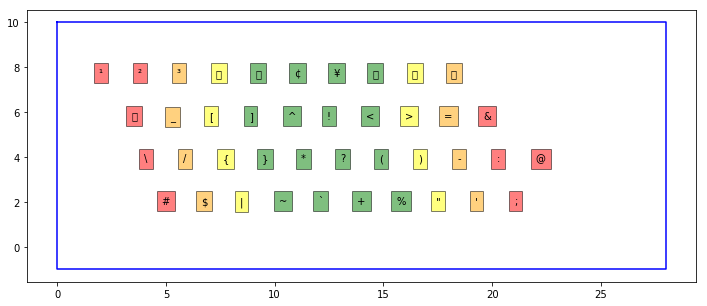

In [18]:
plotKeyboard(neo2Keyboard, desiredLayer = 2)

## Compare Optimized result 

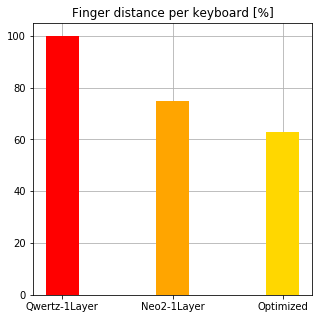

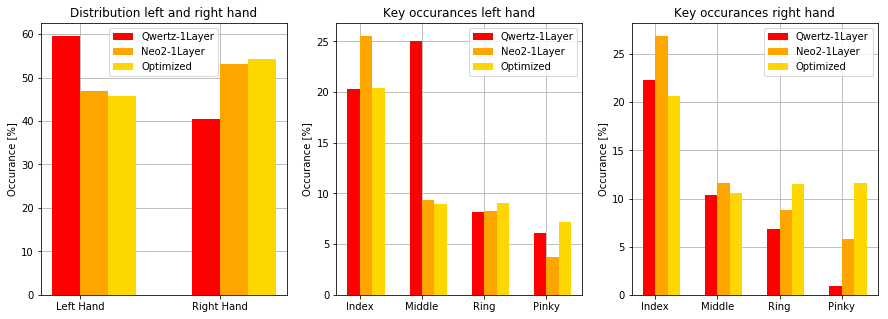

In [28]:
#Take only first layer of qwertz and neo because optimized keyboard has only one layer!

qwertzKeyboard = Keyboard("Qwertz-1Layer", filePath="Layouts/Qwertz-1Layer.csv")
neo2Keyboard = Keyboard("Neo2-1Layer", filePath="Layouts/Neo2-1Layer.csv")
optimizedKeyboard = Keyboard("Optimized", filePath="Results/Neo 2 optimized Mod fixed.csv")

keyboardList = [qwertzKeyboard, neo2Keyboard, optimizedKeyboard]

text = readText("Text/FranzJung.txt")
text = text.replace("\r", "")
text = text.replace("\t", "")
text = text.lower()

#text = "abcd efgh"

leftHandHistArr = [] # 4 x n array with histogram of four fingers for n keyboards
rightHandHistArr = [] # 4 x n array with histogram of four fingers for n keyboards
keyboardNames = [] # 1 x n array with names of n keyboards
dataLeftRightArr = [] # 2 x n array with distribution of left and right hand 
fingerDistArr = [] # 1 x n array with finger distance of n keyboards


for keyboard in keyboardList:
    #Type text with current keyboard
    Keyboard.typeText(text, keyboard)
    #Get results for fingers of left and right hand
    histLeft = keyboard.leftHand.getPressCount()
    histRight = keyboard.rightHand.getPressCount()
    
    #Calculate distribution over left and right hand
    keyCountTotal = sum(histRight) + sum(histLeft)
    dataLeftRight = [sum(histLeft) / keyCountTotal * 100, sum(histRight) / keyCountTotal * 100]
    dataLeftRightArr.append(dataLeftRight)
                     
    #Calculate relative distribution over fingers of left and right hand
    histLeftRel = [histVal / keyCountTotal * 100 for histVal in histLeft]
    histRightRel = [histVal / keyCountTotal * 100 for histVal in histRight]
    leftHandHistArr.append(histLeftRel)
    rightHandHistArr.append(histRightRel)
    
    #Add finger distance to array
    fingerDistArr.append(keyboard.fingerTravel)
   
    keyboardNames.append(keyboard.name)

# Calculate finger distance in %   
maxFingerDist = max(fingerDistArr)
fingerDistArr = [val / maxFingerDist *100 for val in fingerDistArr]

#Plot results

fig1, ax1 = plt.subplots(figsize=(5, 5))
plotFingerDistance(ax1, data = fingerDistArr, nameArr = keyboardNames, title = 'Finger distance per keyboard [%]')

fig2, ax2 = plt.subplots(1,3, figsize=(15, 5))

plotLeftHandRightHand(ax2[0], data = dataLeftRightArr, nameArr = keyboardNames, title = 'Distribution left and right hand')
plotHandHist(ax2[1], data = leftHandHistArr, nameArr = keyboardNames, title = 'Key occurances left hand')
plotHandHist(ax2[2], data = rightHandHistArr, nameArr = keyboardNames, title = 'Key occurances right hand')




# Tests
[Go up](#toc)

## Unit tests

.........
----------------------------------------------------------------------
Ran 9 tests in 0.246s

OK


Saved layout to: savedQwertz


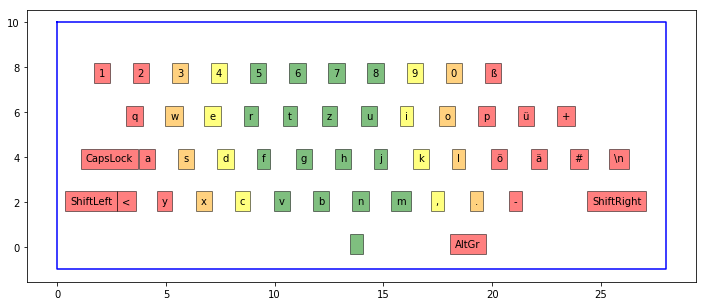

In [26]:
import unittest

testString = "abcdefghijklmnopqrstuvwxyz,.1234567890ß \n"
qwertzKeyboard = Keyboard("Qwertz", filePath="Layouts/Qwertz-1Layer.csv")
neo2Keyboard = Keyboard("Neo2", filePath="Layouts/Neo2-1Layer.csv")
wordDistBaseline = 100
histDesired = [0.25, 0.25, 0.25, 0.25]

class TestDemo(unittest.TestCase):
    """Example of how to use unittest in Jupyter."""
    
#     testString = "abcdefghijklmnopqrstuvwxyz,.1234567890ß \n"
#     qwertzKeyboard = Keyboard("Qwertz")
#     neo2Keyboard = Keyboard("Neo2", filePath = "Layouts/Neo2.csv")
    
    def testSaveKeyboard(self):
        
        if os.path.exists("savedQwertz.csv"):
            os.remove("savedQwertz.csv")
        qwertzKeyboard.saveKeyboardLayoutToDisk("savedQwertz")
        
        savedKeyboard = Keyboard("loaded from disk", filePath= "savedQwertz.csv")
        
        dist1, errorCount1, errorList1 = Keyboard.typeText(testString, qwertzKeyboard)
        dist2, errorCount2, errorList2 = Keyboard.typeText(testString, savedKeyboard)

        self.assertEqual(dist1, dist2)
        self.assertEqual(errorCount1, errorCount2)
        self.assertEqual(errorList1, errorList2)
        
#         import datetime
#         print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    def testFileReader(self):
        text = readText("Text/KeyboardHist.txt")
        self.assertEqual(len(text), 38920)
        
    def testKeyboardConstructor(self):
        
        keyboardFromFile = Keyboard("From file")
        keyboardFromMemory = Keyboard("From memory", fromFile=False, keyDict=qwertzKeyboard.keyDict)
        
        dist1, errorCount1, errorList1 = Keyboard.typeText(testString, keyboardFromFile)
        dist2, errorCount2, errorList2 = Keyboard.typeText(testString, keyboardFromMemory)
        
        self.assertEqual(dist1, dist2)
        self.assertEqual(errorCount1, errorCount2)
        self.assertEqual(errorList1, errorList2)
    
    def testKeyboardLength(self):
        self.assertEqual(len(qwertzKeyboard.keyDict), 52)
        self.assertEqual(len(neo2Keyboard.keyDict), 51)

    def testTypeTextQwertz(self):
        #Test qwertz
        dist, errorCount, errorList = Keyboard.typeText(testString, qwertzKeyboard)
        self.assertAlmostEqual(dist, 110, delta=0.5)
        self.assertEqual(errorCount, 0)
        self.assertEqual(len(errorList), 0)
        #Type again
        dist, errorCount, errorList = Keyboard.typeText(testString, qwertzKeyboard)
        self.assertAlmostEqual(dist, 110, delta=0.5)
        self.assertEqual(errorCount, 0)
        self.assertEqual(len(errorList), 0)
        
    def testTypeTextNeo2(self):
        #Test Neo2
        dist, errorCount, errorList = Keyboard.typeText(testString, neo2Keyboard)
        self.assertAlmostEqual(dist, 100, delta=0.5)
        self.assertEqual(errorCount, 0)
        self.assertEqual(len(errorList), 0)
        #Type again
        dist, errorCount, errorList = Keyboard.typeText(testString, neo2Keyboard)
        self.assertAlmostEqual(dist, 100, delta=0.5)
        self.assertEqual(errorCount, 0)
        self.assertEqual(len(errorList), 0)
        
    def testCreatePopulation(self):
        population = create_starting_population(10, qwertzKeyboard)
        self.assertEqual(len(population), 10)
        distArr = []
        for i in range(len(population)):
            dist, errorCount, errorList = Keyboard.typeText(testString, population[i])
            distArr.append(dist)
            self.assertGreater(dist, 80)
            self.assertEqual(errorCount, 0)
            self.assertEqual(len(errorList), 0)
        scores = score_population(population, testString, wordDistBaseline, histDesired)
        #Type again and verify its the same result as before as well as in scores  
        for i in range(len(population)):
            dist, errorCount, errorList = Keyboard.typeText(testString, population[i])
            self.assertEqual(distArr[i], dist)
            #self.assertEqual(scores[i], dist)
            self.assertEqual(errorCount, 0)
            self.assertEqual(len(errorList), 0)  
            
    def testCrossover(self):
        population = create_starting_population(10, qwertzKeyboard)
        
        new1, new2 = crossover(population[0], population[1], qwertzKeyboard)
        #Test new1
        dist, errorCount, errorList = Keyboard.typeText(testString, new1)
        self.assertGreater(dist, 80)
        self.assertEqual(errorCount, 0)
        self.assertEqual(len(errorList), 0)
        
        #Test new2
        dist, errorCount, errorList = Keyboard.typeText(testString, new2)
        self.assertGreater(dist, 80)
        self.assertEqual(errorCount, 0)
        self.assertEqual(len(errorList), 0)
        
        #Test qwertz
        dist, errorCount, errorList = Keyboard.typeText(testString, qwertzKeyboard)
        self.assertAlmostEqual(dist, 110, delta=0.5)
        self.assertEqual(errorCount, 0)
        self.assertEqual(len(errorList), 0)
        
        #Test Neo2
        dist, errorCount, errorList = Keyboard.typeText(testString, neo2Keyboard)
        self.assertAlmostEqual(dist, 100, delta=0.5)
        self.assertEqual(errorCount, 0)
        self.assertEqual(len(errorList), 0) 
        
    def testMutate(self):
        keyboardToMutate = Keyboard("Qwertz")
        
        distBefore, errorCount, errorList = Keyboard.typeText(testString, keyboardToMutate)
        
        self.assertGreater(distBefore, 80)
        self.assertEqual(errorCount, 0)
        self.assertEqual(len(errorList), 0)
        
        # Mutate with probabilty = 0 --> Check for same result
        mutate(keyboardToMutate, 0)
        distAfter, errorCount, errorList = Keyboard.typeText(testString, keyboardToMutate)
        self.assertEqual(errorCount, 0)
        self.assertEqual(len(errorList), 0)
        self.assertEqual(distBefore, distAfter)
        
        # Mutate with probabilty = 1 --> Check for different result
        mutate(keyboardToMutate, 1)
        distAfter, errorCount, errorList = Keyboard.typeText(testString, keyboardToMutate)
        self.assertEqual(errorCount, 0)
        self.assertEqual(len(errorList), 0)
        self.assertGreaterEqual(abs(distBefore - distAfter), 0)
        
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

## Timing

## Spielwiese

In [27]:
from pympler import muppy
all_objects = muppy.get_objects()
len(all_objects)    

# import types
# my_types = muppy.filter(all_objects, Type=Keyboard)
# len(my_types)   

from pympler import summary
sum1 = summary.summarize(all_objects)
summary.print_(sum1)   

                       types |   # objects |   total size
============================ | =========== | ============
                 <class 'str |      118257 |     15.77 MB
                <class 'dict |       20608 |      8.33 MB
                <class 'list |       23496 |      4.49 MB
                <class 'code |       25608 |      3.54 MB
                <class 'type |        2990 |      3.04 MB
                 <class 'set |        2229 |      1.01 MB
               <class 'tuple |       12678 |    837.74 KB
             <class 'weakref |        8424 |    658.12 KB
       <class 'numpy.ndarray |        3367 |    456.23 KB
                 <class 'int |       14202 |    393.68 KB
         function (__init__) |        1848 |    245.44 KB
   <class 'getset_descriptor |        3347 |    235.34 KB
         <class 'abc.ABCMeta |         232 |    234.12 KB
                <class 'cell |        4943 |    231.70 KB
  <class 'wrapper_descriptor |        2635 |    205.86 KB
